In [116]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [117]:
#Load Dataset
Home_data = pd.read_csv('HomeC.csv')
nan_removed = pd.DataFrame.dropna(pd.DataFrame(Home_data))
nan_removed.value_counts()

C:\Users\M-SI\AppData\Local\Temp\ipykernel_12884\675098868.py:2: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  Home_data = pd.read_csv('HomeC.csv')


time        use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  Solar [kW]  temperature  icon         humidity  visibility  summary     apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability
1451624400  0.932833  0.003483  0.932833            0.000033         0.020700        0.061917        0.442633          0.124150     0.006983          0.013083          0.000417         0.000150         0.000000         0.031350   0.001017   0.004067        0.001517          0.003483    36.14        clear-night  0.62      10.00       Clear       29.26                1016.91   9.18       cloudCover  282.0        0.0000           24.40     0.00                 1
1451960350  0.498450  0.054750  0.498450            0.000000         0.020100

In [118]:
# remove duplicates values for temperature, icon, humidity, visibility, summary, apparentTemperature, pressure, windSpeed, cloudCover, windBearing, precipIntensity, dewPoint, and precipProbability
duplicate_removed = nan_removed.drop_duplicates(subset=['temperature', 'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'], keep='first')
duplicate_removed['summary'].value_counts()

summary
Clear                       6549
Partly Cloudy               1083
Light Rain                   476
Drizzle                      180
Overcast                     105
Rain                          90
Mostly Cloudy                 79
Light Snow                    76
Flurries                      31
Breezy                        27
Snow                          20
Breezy and Partly Cloudy      18
Foggy                         17
Rain and Breezy                3
Heavy Snow                     3
Flurries and Breezy            2
Breezy and Mostly Cloudy       1
Dry                            1
Name: count, dtype: int64

In [119]:
random_selection = duplicate_removed.sample(n=2500, replace=False, random_state=42)
random_selection['summary'].value_counts()

summary
Clear                       1888
Partly Cloudy                309
Light Rain                   120
Drizzle                       45
Overcast                      34
Rain                          30
Mostly Cloudy                 27
Light Snow                    21
Flurries                       9
Snow                           6
Breezy                         3
Breezy and Partly Cloudy       3
Foggy                          2
Rain and Breezy                2
Breezy and Mostly Cloudy       1
Name: count, dtype: int64

In [120]:
# split the dataframe into 3 type of summary Rain, Cloudy, and Clear
rain = duplicate_removed[duplicate_removed['summary'] == 'Rain']
drizzle = duplicate_removed[duplicate_removed['summary'] == 'Drizzle']
overcast = duplicate_removed[duplicate_removed['summary'] == 'Overcast']
# other = random_selection[(random_selection['summary'] != 'Clear') & (random_selection['summary'] != 'Partly Cloudy')]
# other['summary'] = 'Other'

In [121]:
# combine the 3 dataframe into 1
frames = [rain, drizzle, overcast]
result = pd.concat(frames)

# change the summary into numerical value
result['summary'] = result['summary'].map({'Rain': 0, 'Drizzle': 1, 'Overcast': 2})
result = result.reset_index(drop=True)

In [122]:
X = result.iloc[:,[0,5,7,9]].values
y = result['summary'].values
y = y.reshape([375,1])

In [123]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # initialize weights randomly
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        
        # initialize biases to 0
        self.bias1 = np.zeros((1, self.hidden_size))
        self.bias2 = np.zeros((1, self.output_size))
    
    def fit(self, X, y, epochs=1000):
        for epoch in range(epochs):
            # feedforward
            layer1 = X.dot(self.weights1) + self.bias1
            activation1 = sigmoid(layer1)
            layer2 = activation1.dot(self.weights2) + self.bias2
            activation2 = sigmoid(layer2)
            
            # backpropagation
            error = activation2 - y
            d_weights2 = activation1.T.dot(error * sigmoid_derivative(layer2))
            d_bias2 = np.sum(error * sigmoid_derivative(layer2), axis=0, keepdims=True)
            error_hidden = error.dot(self.weights2.T) * sigmoid_derivative(layer1)
            d_weights1 = X.T.dot(error_hidden)
            d_bias1 = np.sum(error_hidden, axis=0, keepdims=True)
            
            # update weights and biases
            self.weights2 -= self.learning_rate * d_weights2
            self.bias2 -= self.learning_rate * d_bias2
            self.weights1 -= self.learning_rate * d_weights1
            self.bias1 -= self.learning_rate * d_bias1
#Prediction    
    def predict(self, X):
        layer1 = X.dot(self.weights1) + self.bias1
        activation1 = sigmoid(layer1)
        layer2 = activation1.dot(self.weights2) + self.bias2
        activation2 = sigmoid(layer2)
        return (activation2 > 0.5).astype(int)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train = X_train.astype(float)  # Convert X_train to float
X_test = X_test.astype(float)  # Convert X_test to float
# create an instance of the MLP class
mlp = MLP(input_size=4, hidden_size=8, output_size=1)
# train the MLP on the training data
mlp.fit(X_train, y_train)
# make predictions on the test data
y_pred = mlp.predict(X_test)

C:\Users\M-SI\AppData\Local\Temp\ipykernel_12884\2210126407.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [133]:
# evaluate the accuracy of the MLP
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.49122807017543857


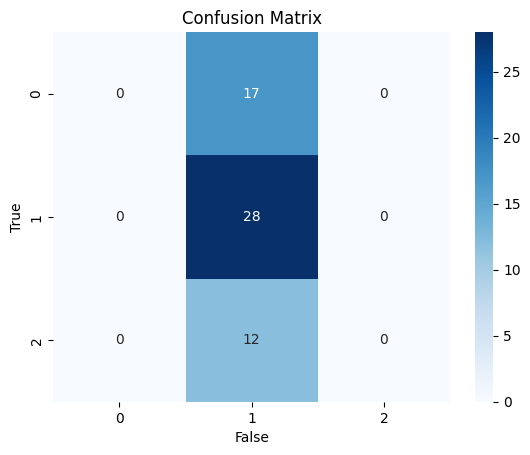

In [132]:
# Calculate confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred) 
  
sns.heatmap(conf_matrix, annot = True, cmap= 'Blues') 
plt.ylabel('True') 
plt.xlabel('False') 
plt.title('Confusion Matrix') 
plt.show()